<a href="https://colab.research.google.com/github/Ikeda33/codespaces-railstutorial/blob/main/seblock_50epoch_flower_D_se_G_sa_FID_KID_devide_1_color_relativistic1_hinge.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#パッケージのダウンロード


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import argparse

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim

In [5]:
import torchvision.transforms as transforms

In [6]:
import torchvision.datasets as dset

In [7]:
import torchvision.utils as vutils

In [8]:
import matplotlib.pyplot as plt
import numpy as np
import tqdm

In [9]:
import glob

In [10]:
from torch.utils.data import Dataset
from PIL import Image

In [11]:
from torch.utils.data import DataLoader
import torchvision

In [12]:
!pip install torchmetrics
!pip install torchmetrics[image]

!pip install torch-fidelity

from torchmetrics.image.inception import InceptionScore


import torchmetrics
import torch_fidelity

import torch
_ = torch.manual_seed(123)
from torchmetrics.image.fid import FrechetInceptionDistance
fid = FrechetInceptionDistance(feature=2048)

from torchmetrics.image.kid import KernelInceptionDistance


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 806.1/806.1 kB 7.2 MB/s eta 0:00:00


Downloading: "https://github.com/toshas/torch-fidelity/releases/download/v0.2.0/weights-inception-2015-12-05-6726825d.pth" to /root/.cache/torch/hub/checkpoints/weights-inception-2015-12-05-6726825d.pth
100%|██████████| 91.2M/91.2M [00:00<00:00, 237MB/s]


In [13]:
kid = KernelInceptionDistance(subset_size=15)

/usr/local/lib/python3.10/dist-packages/torchmetrics/utilities/prints.py:43: UserWarning: Metric `Kernel Inception Distance` will save all extracted features in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)  # noqa: B028


In [14]:
#ハイパーパラメータの設定

In [15]:
parser = argparse.ArgumentParser()
parser.add_argument("--n_epoch", type = int, default=50)
parser.add_argument("--batch_size", type = int, default=32)
parser.add_argument("--lr_g", type = float, default=2e-4)
parser.add_argument("--lr_d", type = float, default=3e-4)
parser.add_argument("--nch_g", type = int, default=64)
parser.add_argument("--nch_d", type = int, default=64)
parser.add_argument("--z_dim", type = int, default=100)
parser.add_argument("--beta1", type = float, default=0.5)

opt = parser.parse_args(args=[])
print(opt)

Namespace(n_epoch=50, batch_size=32, lr_g=0.0002, lr_d=0.0003, nch_g=64, nch_d=64, z_dim=100, beta1=0.5)


In [16]:
class ImageDataset(Dataset):
    def __init__(self,  transform = None):
        super().__init__()
        self.file_list = glob.glob("/content/drive/MyDrive/102flowers (2)/jpg/*.jpg")#/content/drive/MyDrive/img_align_celeba.zip
        #self.file_list = glob.glob("/content/drive/MyDrive/cityscapes/cityscapes_data/train/*.jpg" )#/content/drive/MyDrive/cityscapes/cityscapes_data/train
        #self.file_list = glob.glob("/content/drive/MyDrive/Test/**/*.jpg" )#fruits
       # self.file_list = glob.glob("/content/drive/MyDrive/img_align_celeba.zip/jpg/*.jpg")#C:\Users\ikeda\Downloads\img_align_celeba\img_align_celeba
        #self.file_list = glob.glob("/content/drive/MyDrive/–¢Šm”F 758452(1).crdownload/*.jpg")
        self.transform = transform


    def __getitem__(self, index):
        if self.transform is not None:
            img = self.transform(Image.open(self.file_list[index]))
        else:
            img = Image.open(self.file_list[index])
        return img

    def __len__(self):
        return len(self.file_list)

In [17]:
from torchvision.transforms.transforms import CenterCrop

transform = transforms.Compose([

    transforms.Resize(80),
    transforms.CenterCrop(64),
    transforms.ToTensor(),
                               transforms.Normalize((0.5,),(0.5,))])

In [18]:
#dataset = dset.MNIST("./", train = True, download = True,transform = transform)
dataset = ImageDataset(transform = transform)
#dataset = torchvision.datasets.CelebA("./", split = "test", download = True,transform = transform) #Cityscapes
#dataset = torchvision.datasets.Cityscapes("C:\Users\ikeda\Downloads\cityscapes\cityscapes_data\cityscapes_data", split='train', mode='fine', target_type='color')


In [19]:
dataloader = DataLoader(dataset = dataset, batch_size = opt.batch_size,num_workers = 2,  shuffle = True)

In [20]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find("Conv") != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find("BatchNorm") != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)


In [21]:
#モデルの設定

In [22]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels):
        super().__init__()
        out_channels = in_channels
        self.conv1 = nn.utils.spectral_norm(nn.Conv2d(in_channels, out_channels,kernel_size = 3, padding = 1))
        self.conv2 = nn.utils.spectral_norm(nn.Conv2d(out_channels, out_channels,kernel_size = 3, padding = 1))
        self.conv3 = nn.utils.spectral_norm(nn.Conv2d(in_channels, out_channels,kernel_size = 1, padding = 0))#kernel_size -> チャネル数だけ変化させること
        self.bn = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU()
        self.se_block_0 = SE(out_channels)
    def shortcut(self, x):
        x = self.conv3(x)
        x = self.bn(x)
        return x

    def forward(self, x):
        identity = x#入力
        x = self.conv1(x)
        x = self.se_block_0(x)
        x = self.bn(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.se_block_0(x)
        x = self.bn(x)
        x = x + self.shortcut(identity)
        return x

In [23]:
class ResidualBlock_G(nn.Module):
    def __init__(self, in_channels):
        super().__init__()
        out_channels = in_channels
        self.conv1 = nn.utils.spectral_norm(nn.ConvTranspose2d(in_channels, out_channels,kernel_size = 3, padding = 1))
        self.conv2 = nn.utils.spectral_norm(nn.ConvTranspose2d(out_channels, out_channels,kernel_size = 3, padding = 1))
        self.conv3 = nn.utils.spectral_norm(nn.ConvTranspose2d(in_channels, out_channels,kernel_size = 1, padding = 0))#kernel_size -> チャネル数だけ変化させること
        self.bn = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU()
        self.se_block_0 = SE_G(out_channels)
    def shortcut(self, x):
        x = self.conv3(x)
        x = self.bn(x)
        return x

    def forward(self, x):
        identity = x#入力
        x = self.conv1(x)
        x = self.se_block_0(x)
        x = self.bn(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.se_block_0(x)
        x = self.bn(x)
        x = x + self.shortcut(identity)
        return x

In [24]:
class ResidualBlock_1(nn.Module):#実質パディングとスペクトラム正規化とインスタンス正規化
  def __init__(self, in_channels):
    super().__init__()
    self.conv_layers = nn.Sequential(
        nn.ReflectionPad2d(1),
        nn.utils.spectral_norm(nn.Conv2d(in_channels, in_channels, 3)),
        nn.InstanceNorm2d(in_channels),
        nn.ReLU(inplace = True),

        nn.ReflectionPad2d(1),
        nn.utils.spectral_norm(nn.Conv2d(in_channels, in_channels, 3)),
        nn.InstanceNorm2d(in_channels),

    )
  def forward(self, x):
    out = self.conv_layers(x)
    out = out + x
    return out

In [25]:
class SelfAttention(nn.Module):
    def __init__(self, in_channels):
        super().__init__()
        n_divide = in_channels
        #out_channels = in_channels // n_divide
        out_channels = 1

        self.fx_1x1 = (nn.Conv2d(in_channels, out_channels, kernel_size = 1))#nn.utils.spectral_norm
        self.gx_1x1 = (nn.Conv2d(in_channels, out_channels, kernel_size = 1))#
        self.hx_1x1 = (nn.Conv2d(in_channels, in_channels, kernel_size = 1))#
        self.gamma = nn.Parameter(torch.zeros(1))
        self.softmax = nn.Softmax(dim = -2)#規格化するため -2


    def forward(self, x):
        B, C, H, W = x.size()
        #x = nn.LayerNorm([C,H,W])#input.size()[1:]
        fx = self.fx_1x1(x).view(B, -1, H*W).permute(0,2,1)
        gx = self.gx_1x1(x).view(B, -1, H*W)
        hx = self.hx_1x1(x).view(B, -1, H*W)

        s_mtx = torch.bmm(fx, gx)
        attention = self.softmax(s_mtx)

        o =torch.bmm(hx, attention)
        o = o.view(B, -1, H, W)
        out = x + self.gamma * o
        return out

In [26]:
#import torch
#from layers.transformer.ScaledDotProductAttention import ScaledDotProductAttention
#from torch import nn


class MultiHeadAttention(nn.Module):
    def __init__(self, in_channels, h = 8):
        super().__init__()
        d_model = in_channels
        self.d_model = in_channels
        self.h = in_channels
        self.d_k = d_model // h
        self.d_v = d_model // h
        self.fx_1x1 = (nn.Conv2d(in_channels, in_channels//self.h, kernel_size = 1))
        self.gx_1x1 = (nn.Conv2d(in_channels, in_channels//self.h, kernel_size = 1))
        self.hx_1x1 = nn.utils.spectral_norm(nn.Conv2d(in_channels, in_channels, kernel_size = 1))
        self.qkv = nn.utils.spectral_norm(nn.Conv2d(in_channels, 3 * in_channels, kernel_size = 1))

#        self.scaled_dot_product_attention = SelfAttention(self.d_model)

        self.linear = nn.Linear(self.h * self.d_v, d_model)
       # self.fx_1x1 = (nn.Conv2d(in_channels, out_channels, kernel_size = 1))#nn.utils.spectral_norm
        #self.gx_1x1 = (nn.Conv2d(in_channels, out_channels, kernel_size = 1))#
        #self.hx_1x1 = (nn.Conv2d(in_channels, in_channels, kernel_size = 1))#
        self.gamma = nn.Parameter(torch.zeros(1))
        self.softmax = nn.Softmax(dim = -2)#規格化するため -2

        self.se_block_0 = SE(in_channels)
        self.relu = nn.ReLU()

    def forward(self, x ) -> torch.Tensor:
        B, C, H, W = x.size()
        qkv = self.qkv(x)
        self.q, self.k, self.v = qkv.chunk(3, dim = 1)

        #self.q = self.se_block_0(self.q)
        #self.k = self.se_block_0(self.k)
        #self.v = self.se_block_0(self.v)

        """Scaled dot product attention"""
       # attention_output = self.scaled_dot_product_attention(self.q, self.k, self.v)  # (head*batch_size, seq_len, d_model)
        B, C, H, W = self.q.size()
        #x = nn.LayerNorm([C,H,W])#input.size()[1:]
        fx = self.fx_1x1(self.q).view(B, -1, H*W).permute(0,2,1)
        gx = self.gx_1x1(self.k).view(B, -1, H*W)
        hx = self.hx_1x1(self.v).view(B, -1, H*W)
       # fx = self.q.view(B, -1, H*W).permute(0,2,1)
       # gx = self.k.view(B, -1, H*W)
       # hx = self.v.view(B, -1, H*W)

        s_mtx = torch.bmm(fx, gx)
        attention = self.softmax(s_mtx)

        o =torch.bmm(hx, attention)
        o = o.view(B, -1, H, W)
        out = x + self.gamma * o

        #out = out.repeat(1,self.h*1,1,1)

        #out = torch.chunk(out, self.h, dim=1)
       # out = torch.cat(out, dim=1)

        """Linear after scaled dot product attention"""
        #output = self.linear(out)
        return out


In [27]:

class MultiHeadAttention_G(nn.Module):
    def __init__(self, in_channels, h = 8):
        super().__init__()
        d_model = in_channels
        self.d_model = in_channels
        self.h = in_channels
        self.d_k = d_model // h
        self.d_v = d_model // h
        self.fx_1x1 = (nn.ConvTranspose2d(in_channels, in_channels//self.h, kernel_size = 1))
        self.gx_1x1 = (nn.ConvTranspose2d(in_channels, in_channels//self.h, kernel_size = 1))
        self.hx_1x1 = nn.utils.spectral_norm(nn.ConvTranspose2d(in_channels, in_channels, kernel_size = 1))
        self.qkv = nn.utils.spectral_norm(nn.ConvTranspose2d(in_channels, 3 * in_channels, kernel_size = 1))

#        self.scaled_dot_product_attention = SelfAttention(self.d_model)

        self.linear = nn.Linear(self.h * self.d_v, d_model)
       # self.fx_1x1 = (nn.Conv2d(in_channels, out_channels, kernel_size = 1))#nn.utils.spectral_norm
        #self.gx_1x1 = (nn.Conv2d(in_channels, out_channels, kernel_size = 1))#
        #self.hx_1x1 = (nn.Conv2d(in_channels, in_channels, kernel_size = 1))#
        self.gamma = nn.Parameter(torch.zeros(1))
        self.softmax = nn.Softmax(dim = -2)#規格化するため -2

        self.se_block_0 = SE_G(in_channels)
        self.relu = nn.ReLU()

    def forward(self, x ) -> torch.Tensor:
        B, C, H, W = x.size()
        qkv = self.qkv(x)
        qkv = self.relu(qkv)
        self.q, self.k, self.v = qkv.chunk(3, dim = 1)

        #self.q = self.se_block_0(self.q)
        #self.k = self.se_block_0(self.k)
        #self.v = self.se_block_0(self.v)
        """Scaled dot product attention"""
       # attention_output = self.scaled_dot_product_attention(self.q, self.k, self.v)  # (head*batch_size, seq_len, d_model)
        B, C, H, W = self.q.size()
        #x = nn.LayerNorm([C,H,W])#input.size()[1:]
        fx = self.fx_1x1(self.q).view(B, -1, H*W).permute(0,2,1)
        gx = self.gx_1x1(self.k).view(B, -1, H*W)
        hx = self.hx_1x1(self.v).view(B, -1, H*W)
       # fx = self.q.view(B, -1, H*W).permute(0,2,1)
       # gx = self.k.view(B, -1, H*W)
       # hx = self.v.view(B, -1, H*W)

        s_mtx = torch.bmm(fx, gx)
        attention = self.softmax(s_mtx)

        o =torch.bmm(hx, attention)
        o = o.view(B, -1, H, W)
        out = x + self.gamma * o

        #out = out.repeat(1,self.h*1,1,1)

        #out = torch.chunk(out, self.h, dim=1)
       # out = torch.cat(out, dim=1)

        """Linear after scaled dot product attention"""
        #output = self.linear(out)
        return out

In [28]:
class SelfAttention_G(nn.Module):
    def __init__(self, in_channels):
        super().__init__()
        n_divide = in_channels
        out_channels = in_channels // n_divide
      #  out_channels = 1

        self.fx_1x1 = nn.utils.spectral_norm(nn.ConvTranspose2d(in_channels, out_channels, kernel_size = 1))
        self.gx_1x1 = nn.utils.spectral_norm(nn.ConvTranspose2d(in_channels, out_channels, kernel_size = 1))
        self.hx_1x1 = nn.utils.spectral_norm(nn.ConvTranspose2d(in_channels, in_channels, kernel_size = 1))
        self.gamma = nn.Parameter(torch.zeros(1))
        self.softmax = nn.Softmax(dim = -2)#規格化するため -2


    def forward(self, x):
        B, C, H, W = x.size()
        fx = self.fx_1x1(x).view(B, -1, H*W).permute(0,2,1)
        gx = self.gx_1x1(x).view(B, -1, H*W)
        hx = self.hx_1x1(x).view(B, -1, H*W)

        s_mtx = torch.bmm(fx, gx)
        attention = self.softmax(s_mtx)

        o =torch.bmm(hx, attention)
        o = o.view(B, -1, H, W)
        out = x + self.gamma * o
        return out

In [29]:
class PF(nn.Module):#poolformer
    def __init__(self, in_channels , out_channels):
        super().__init__()
        self.conv1 = nn.utils.spectral_norm(nn.Conv2d(in_channels, out_channels,kernel_size=3, padding=1))#kernel_size=4, stride=2, padding=1
        self.conv2 = nn.utils.spectral_norm(nn.Conv2d(out_channels, out_channels,kernel_size = 3, padding = 1))
        self.conv3 = nn.utils.spectral_norm(nn.Conv2d(in_channels, out_channels,kernel_size = 1, padding = 0))#kernel_size -> チャネル数だけ変化させること
        self.pre_bn = nn.BatchNorm2d(in_channels)
        self.bn = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU()
        self.pool = nn.AvgPool2d(kernel_size = 3, stride = 1, padding = 3//2, count_include_pad=False)
        self.flat = nn.Flatten()
    def shortcut(self, x):
        x = self.conv3(x)
        x = self.bn(x)
        return x

    def forward(self, x):
        identity = x#入力
        x = self.pre_bn(x)
        x = self.pool(x) -x
        x = x + identity

        identity = x#入力
        x = self.pre_bn(x)
        x= self.flat(x)
        x = self.conv1(x)
        x = self.relu(x)
        x = x + self.shortcut(identity)
        return x

In [30]:
"""    def __init__(self, in_channels):
        super().__init__()
        n_divide = 8
        out_channels = in_channels // n_divide
        self.dim = 3

        self.fx_1x1 = (nn.Conv2d(in_channels, out_channels, kernel_size = 1))#nn.utils.spectral_norm
        self.gx_1x1 = (nn.Conv2d(in_channels, out_channels, kernel_size = 1))#
        self.hx_1x1 = (nn.Conv2d(in_channels, in_channels, kernel_size = 1))#
        self.gamma = nn.Parameter(torch.zeros(1))
        self.softmax = nn.Softmax(dim = -2)#規格化するため -2
        self.conv1 = nn.utils.spectral_norm(nn.Conv2d(in_channels, out_channels,kernel_size=3, padding=1))#kernel_size=4, stride=2, padding=1
        self.conv2 = nn.utils.spectral_norm(nn.Conv2d(out_channels, out_channels,kernel_size = 3, padding = 1))
        self.conv3 = nn.utils.spectral_norm(nn.Conv2d(in_channels, out_channels,kernel_size = 1, padding = 0))#kernel_size==1 -> チャネル数だけ変化させること
        self.pre_bn = nn.BatchNorm2d(in_channels)
        self.bn = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU()
        self.pool= nn.AvgPool2d(kernel_size =self.dim , stride = 1, padding = 0, count_include_pad=False)
        self.sigmoid = nn.Sigmoid()


    def forward(self, x):
        B, C, H, W = x.size()
        z = self.pre_bn(x)
        z = self.pool(z, self.dim = H)

        z = self.conv1(z)
        z = self.relu(z)

        z = self.conv2(z)
        z = self.sigmoid(z)

        z = torch.einsum("bchw,bchw->bchw",(x, z))
        out = x + self.gamma * z
        return out
"""

'    def __init__(self, in_channels):\n        super().__init__()\n        n_divide = 8\n        out_channels = in_channels // n_divide\n        self.dim = 3\n\n        self.fx_1x1 = (nn.Conv2d(in_channels, out_channels, kernel_size = 1))#nn.utils.spectral_norm\n        self.gx_1x1 = (nn.Conv2d(in_channels, out_channels, kernel_size = 1))#\n        self.hx_1x1 = (nn.Conv2d(in_channels, in_channels, kernel_size = 1))#\n        self.gamma = nn.Parameter(torch.zeros(1))\n        self.softmax = nn.Softmax(dim = -2)#規格化するため -2\n        self.conv1 = nn.utils.spectral_norm(nn.Conv2d(in_channels, out_channels,kernel_size=3, padding=1))#kernel_size=4, stride=2, padding=1\n        self.conv2 = nn.utils.spectral_norm(nn.Conv2d(out_channels, out_channels,kernel_size = 3, padding = 1))\n        self.conv3 = nn.utils.spectral_norm(nn.Conv2d(in_channels, out_channels,kernel_size = 1, padding = 0))#kernel_size==1 -> チャネル数だけ変化させること\n        self.pre_bn = nn.BatchNorm2d(in_channels)\n        self.bn = n

In [31]:
class SE(nn.Module):#SE_Block layerに対して作用するattentionのようなモデル
    def __init__(self, in_channels, reduction=24):
        super().__init__()
        channel = in_channels
        reduction = in_channels
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Sequential(
           # nn.Linear(channel, channel// reduction , bias=False),
            (nn.Conv2d(in_channels, in_channels// reduction,kernel_size = 1, padding = 0)),
            nn.ReLU(inplace=True),
            #nn.Linear(channel // reduction, channel, bias=False),
            (nn.Conv2d(in_channels// reduction,in_channels,kernel_size = 1, padding = 0)),
            nn.Sigmoid()
        )

    def forward(self, x):
        b, c, _, _ = x.size()
        #y = self.avg_pool(x).view(b, c)
        y = self.avg_pool(x)
        y = self.fc(y).view(b, c, 1, 1)
        return x * y.expand_as(x)




In [32]:
class SE_G(nn.Module):#SE_Block layerに対して作用するattentionのようなモデル
    def __init__(self, in_channels, reduction=24):
        super().__init__()
        channel = in_channels
        reduction = in_channels
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Sequential(
            #nn.Linear(channel, channel// reduction , bias=False),
            nn.utils.spectral_norm(nn.ConvTranspose2d(in_channels, in_channels// reduction,kernel_size = 1, padding = 0)),
            nn.ReLU(inplace=True),
            #nn.Linear(channel // reduction, channel, bias=False),
            nn.utils.spectral_norm(nn.ConvTranspose2d(in_channels// reduction,in_channels,kernel_size = 1, padding = 0)),
            nn.Sigmoid()
        )

    def forward(self, x):
        b, c, _, _ = x.size()
        y = self.avg_pool(x)
        y = self.fc(y).view(b, c, 1, 1)
        return x * y.expand_as(x)

In [33]:
#nn.ConvTranspose2d
class PF_G(nn.Module):#poolformer
    def __init__(self, in_channels , out_channels):
        super().__init__()
        self.conv1 = nn.utils.spectral_norm(nn.ConvTranspose2d(in_channels, out_channels,kernel_size=3, padding=1))
        self.conv2 = nn.utils.spectral_norm(nn.ConvTranspose2d(out_channels, out_channels,kernel_size = 3, padding = 1))
        self.conv3 = nn.utils.spectral_norm(nn.ConvTranspose2d(in_channels, out_channels,kernel_size = 1, padding = 0))#kernel_size -> チャネル数だけ変化させること
        self.pre_bn = nn.BatchNorm2d(in_channels)
        self.bn = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU()
        self.pool = nn.AvgPool2d(kernel_size = 3, stride = 1, padding = 3//2, count_include_pad=False)
        self.flat = nn.Flatten()
    def shortcut(self, x):
        x = self.conv3(x)
        x = self.bn(x)
        return x

    def forward(self, x):
        identity = x#入力
        x = self.pre_bn(x)
        x = self.pool(x) - x
        x = x + identity

        identity = x#入力
        x = self.pre_bn(x)
        x = self.flat(x)
        x = self.conv1(x)
        x = self.relu(x)
        x = x + self.shortcut(identity)
        return x

In [34]:
"""(((W - K + 2P)/S) + 1)
    Here W = Input size
    K = Filter size
    S = Stride
    P = Padding
    ((Input_size-kernel_size + 2*Padding)/stride)+ 1
    この式を使用できます[(W−K+2P)/S]+1。

W は入力ボリュームです - あなたの場合は 128
Kはカーネルサイズです - あなたの場合は5です
P はパディングです - あなたの場合は 0 だと思います
S はストライドです - あなたが提供していません。
したがって、次の式に入力します。
for example
Output_Shape = (128-5+0)/1+1

Output_Shape = (124,124,40)
output==1 ,1  = (W - k + 2p)/s = 0   s = 1, p = 0 ,k = W
    """



'(((W - K + 2P)/S) + 1)\n    Here W = Input size\n    K = Filter size\n    S = Stride\n    P = Padding\n    ((Input_size-kernel_size + 2*Padding)/stride)+ 1\n    この式を使用できます[(W−K+2P)/S]+1。\n\nW は入力ボリュームです - あなたの場合は 128\nKはカーネルサイズです - あなたの場合は5です\nP はパディングです - あなたの場合は 0 だと思います\nS はストライドです - あなたが提供していません。\nしたがって、次の式に入力します。\nfor example\nOutput_Shape = (128-5+0)/1+1\n\nOutput_Shape = (124,124,40)\noutput==1 ,1  = (W - k + 2p)/s = 0   s = 1, p = 0 ,k = W\n    '

In [35]:
class VIT(nn.Module):
    def __init__(self, in_channels , out_channels):
        super().__init__()
        self.conv1 = nn.utils.spectral_norm(nn.Conv2d(in_channels, out_channels,kernel_size=3, padding=1))
        self.conv2 = nn.utils.spectral_norm(nn.Conv2d(out_channels, out_channels,kernel_size = 3, padding = 1))
        self.conv3 = nn.utils.spectral_norm(nn.Conv2d(in_channels, out_channels,kernel_size = 1, padding = 0))#kernel_size -> チャネル数だけ変化させること
        self.bn = nn.BatchNorm2d(out_channels)
        self.pre_bn = nn.BatchNorm2d(in_channels)

        self.relu = nn.ReLU()
        self.pool = nn.MaxPool2d(kernel_size = 3, stride = 1, padding = 3//2)
        self.attention = SelfAttention(in_channels)
        self.se_block_0 = SE(in_channels)
        self.se_block_1 = SE(out_channels)

        self.flat = nn.Flatten()

        self.linear_1 = nn.Linear(32,64, bias=False)
        self.linear_2 = nn.Linear( 32,32, bias=False)#if ( 64,32, bias=False)  -> mat1 and mat2 shapes cannot be multiplied (131072x32 and 64x32)


    def shortcut(self, x):
        x = self.conv3(x)
        #x = self.se_block_1(x)
        x = self.bn(x)
        return x

    def forward(self, x):

        identity = x#入力
        x = self.pre_bn(x)
        x = self.se_block_0(x)
       # x = self.attention(x) - x
        x = x + identity


        identity = x#入力
        x = self.pre_bn(x)
       # b, c, h, w = x.size()
        x = self.conv1(x)


      #  x = self.linear_1(x).view(b, -1, h, w)
        x = self.relu(x)
       # x = self.linear_2(x).view(b, -1, h, w)


        x =  self.shortcut(identity) + x
        #x = x + self.shortcut(identity)
        x = self.bn(x)

        return x

In [36]:
#nn.ConvTranspose2d
class VIT_G(nn.Module):
    def __init__(self, in_channels , out_channels):
        super().__init__()
        self.conv1 = nn.utils.spectral_norm(nn.ConvTranspose2d(in_channels, out_channels,kernel_size=3, padding=1))
        self.conv2 = nn.utils.spectral_norm(nn.ConvTranspose2d(out_channels, out_channels,kernel_size = 3, padding = 1))
        self.conv3 = nn.utils.spectral_norm(nn.ConvTranspose2d(in_channels, out_channels,kernel_size = 1, padding = 0))#kernel_size=1 -> チャネル数だけ変化させること
        self.bn = nn.BatchNorm2d(out_channels)
        self.pre_bn = nn.BatchNorm2d(in_channels)
        self.relu = nn.ReLU()
        self.pool = nn.AvgPool2d(kernel_size = 3, stride = 1, padding = 3//2, count_include_pad=False)
        self.attention = MultiHeadAttention_G(in_channels)

    def shortcut(self, x):
        x = self.conv3(x)
        x = self.bn(x)
        return x

    def forward(self, x):
        identity = x#入力
        x = self.pre_bn(x)
        x = self.attention(x) - x
        x = x + identity

        #identity = x#入力
        x = self.pre_bn(x)
        x = self.conv1(x)
        x = self.relu(x)
        x = x + self.shortcut(identity)
        return x

In [37]:
class Generator(nn.Module):
    def __init__(self,pf, vit, resnet,res_net,sa,z_dim = opt.z_dim, ngf = opt.nch_g, nc = 3):# ものくろだからnc=1 カラーならnc=3
        super().__init__()

        self.convt1 = self.conv_trans_layers(z_dim, 8*ngf, 4,1,0 )# ngf = the number of channels

        self.convt2 = self.conv_trans_layers(8*ngf, 4*ngf, 4, 2, 1 )
        self.convt3 = self.conv_trans_layers(4*ngf,  2*ngf, 4,2,1)
        self.convt4 = self.conv_trans_layers(2*ngf,  ngf, 4,2,1 )

        self.pf1 = pf(z_dim, 8*ngf)
        self.vit1 = vit(z_dim, 8*ngf)

        self.pf2 = pf(8*ngf, 4*ngf)
        self.vit2 = vit(8*ngf, 4*ngf)

        self.pf3 = pf(4*ngf,  2*ngf)
        self.vit3 = vit(4*ngf,  2*ngf)

        self.pf4 = pf(2*ngf,  ngf)
        self.vit4 = vit(2*ngf,  ngf)

        self.convt5 = nn.Sequential(
            nn.ConvTranspose2d(ngf, nc, 4, 2, 1),
            #self.conv_trans_layers(ngf, nc, 4,2,1  )
            nn.Tanh()
        )


    @staticmethod
    def conv_trans_layers(in_channels, out_channels, kernel_size, stride, padding, has_norm=True,attention=True, res_net= False, se = False):
        layers = [nn.utils.spectral_norm(nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride, padding))]#spectralnorm
        if has_norm:
            layers.append(nn.BatchNorm2d(out_channels))
        #layers.append(nn.ReLU(inplace = True))
        layers.append(nn.LeakyReLU(0.2, inplace = True))
        if se:
            layers.append(SE_G(out_channels))
        if attention:
            layers.append(SelfAttention_G(out_channels))
        if res_net:
            layers.append(ResidualBlock_G(out_channels))



        net = nn.Sequential(*layers)#listのアンパック

        return net

    def forward(self, x):
        out = self.convt1(x)

        out = self.convt2(out)

        out = self.convt3(out)

        out = self.convt4(out)

        out = self.convt5(out)


        return out

In [38]:
from pickle import FALSE
class Discriminator(nn.Module):
    def __init__(self,pf,vit ,resnet,res_net,sa,nc = 3, ndf = opt.nch_d):# ものくろだからnc=1 カラーならnc=3
        super().__init__()
        self.conv1 = self.conv_layers(nc, ndf)
        self.pf1 = pf(nc,ndf)
        self.vit1 = vit(nc,ndf)

        self.conv2 = self.conv_layers(ndf, 2*ndf, se = True )
        self.pf2 = pf(ndf, 2*ndf)
        self.vit2 = vit(ndf, 2*ndf)

        self.conv3 = self.conv_layers(2*ndf, 4*ndf, se = True )
        self.pf3 = pf(2*ndf, 4*ndf )
        self.vit3 = vit(2*ndf, 4*ndf )

        self.conv4 = self.conv_layers(4*ndf, 8*ndf, se = True)
        self.pf4 = pf(4*ndf, 8*ndf)
        self.vit4 = vit(4*ndf, 8*ndf)

        self.vit5 = vit(8*ndf, 16*ndf)

        self.conv5 =  nn.Conv2d(8*ndf, 1,  4)
        #self.conv6 =  nn.Conv2d(16*ndf, 1,  4)


    @staticmethod
    def conv_layers(in_channels, out_channels, kernel_size=4, stride=2, padding=1, has_batch_norm = True, attention = False, res_net = False, se = False):
        layers = [nn.utils.spectral_norm(nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding))]
        if has_batch_norm:
            layers.append(nn.BatchNorm2d(out_channels))
        layers.append(nn.LeakyReLU(0.2, inplace = True))
        if se:
            layers.append(SE(out_channels))
        if attention:
            layers.append(SelfAttention(out_channels))

        if res_net:
            layers.append(ResidualBlock(out_channels))


        net = nn.Sequential(*layers)#listのアンパック

        return net

    def forward(self, x):
        out = self.conv1(x)

        out = self.conv2(out)

        out = self.conv3(out)

        out = self.conv4(out)

        out = self.conv5(out)

        return out

In [39]:
#モデルのトレーニング

In [40]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [41]:
device

device(type='cuda')

In [42]:
netG = Generator(PF_G,VIT_G,ResidualBlock,ResidualBlock_1,SelfAttention, z_dim=opt.z_dim , ngf=opt.nch_g ).to(device)
netG.apply(weights_init)
print(netG)

netD = Discriminator(PF,VIT,ResidualBlock,ResidualBlock_1,SelfAttention, nc = 3 , ndf=opt.nch_d ).to(device)# ものくろだからnc=1 カラーならnc=3
netD.apply(weights_init)
print(netD)

Generator(
  (convt1): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1))
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2, inplace=True)
    (3): SelfAttention_G(
      (fx_1x1): ConvTranspose2d(512, 1, kernel_size=(1, 1), stride=(1, 1))
      (gx_1x1): ConvTranspose2d(512, 1, kernel_size=(1, 1), stride=(1, 1))
      (hx_1x1): ConvTranspose2d(512, 512, kernel_size=(1, 1), stride=(1, 1))
      (softmax): Softmax(dim=-2)
    )
  )
  (convt2): Sequential(
    (0): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2, inplace=True)
    (3): SelfAttention_G(
      (fx_1x1): ConvTranspose2d(256, 1, kernel_size=(1, 1), stride=(1, 1))
      (gx_1x1): ConvTranspose2d(256, 1, kernel_size=(1, 1), stride=(1, 1))
      (hx_1x1): ConvTranspo

In [43]:
#criterion = nn.BCELoss()
#criterion = torch.nn.HingeEmbeddingLoss()
optimizerG = optim.Adam(netG.parameters(), lr = opt.lr_g, betas= (opt.beta1, 0.999), weight_decay = 1e-5)
optimizerD = optim.Adam(netD.parameters(), lr = opt.lr_d, betas= (opt.beta1, 0.999), weight_decay = 1e-5)

100%|██████████| 103/103 [00:55<00:00,  1.86it/s]


epoch: 0, lossD:0.7618781195103543, lossG:12.085410030142775,lossG_fake:8.340050463338645, lossG_real:3.7453595440364578 ,equality:4.594690919302188


evaluate:122.97792053222656,kid_mean:0.07894439995288849, kid_std:0.01876477710902691,kid_:(tensor(0.0789), tensor(0.0188))


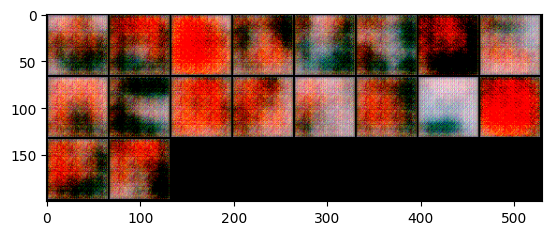

100%|██████████| 103/103 [00:09<00:00, 11.36it/s]


epoch: 1, lossD:0.9049869207394066, lossG:6.7307850735858805,lossG_fake:4.119636797210545, lossG_real:2.611148290842482 ,equality:1.5084885063680633


evaluate:123.67308044433594,kid_mean:0.08503773808479309, kid_std:0.03303486853837967,kid_:(tensor(0.0850), tensor(0.0330))


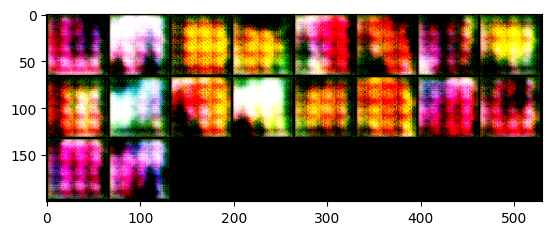

100%|██████████| 103/103 [00:09<00:00, 11.24it/s]


epoch: 2, lossD:0.8795558823977859, lossG:6.598576531826871,lossG_fake:3.9193030977712096, lossG_real:2.679273423639316 ,equality:1.2400296741318937


evaluate:122.7540283203125,kid_mean:0.08423057198524475, kid_std:0.04026983678340912,kid_:(tensor(0.0842), tensor(0.0403))


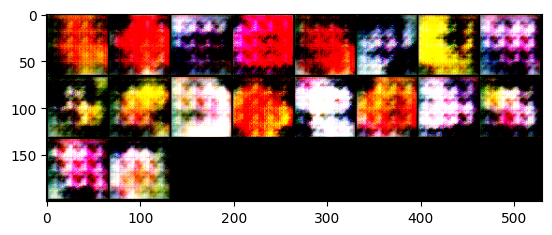

100%|██████████| 103/103 [00:09<00:00, 10.92it/s]


epoch: 3, lossD:1.013469298777071, lossG:6.410399807309641,lossG_fake:3.903450513348996, lossG_real:2.5069493009048758 ,equality:1.3965012124441203


evaluate:118.34841918945312,kid_mean:0.07645194977521896, kid_std:0.03506825864315033,kid_:(tensor(0.0765), tensor(0.0351))


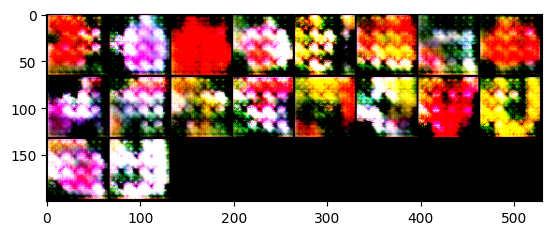

100%|██████████| 103/103 [00:09<00:00, 10.79it/s]


epoch: 4, lossD:0.9154899620894089, lossG:6.297471689946443,lossG_fake:3.799702551758405, lossG_real:2.4977691295077498 ,equality:1.3019334222506553


evaluate:115.45808410644531,kid_mean:0.07705941796302795, kid_std:0.03661732003092766,kid_:(tensor(0.0771), tensor(0.0366))


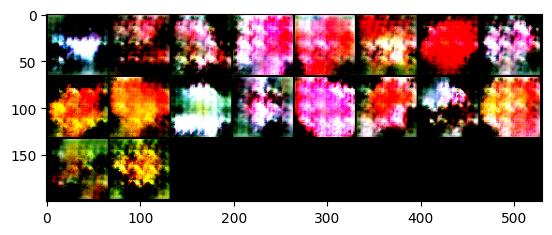

100%|██████████| 103/103 [00:09<00:00, 10.84it/s]


epoch: 5, lossD:0.8835773524439451, lossG:5.853288159787076,lossG_fake:3.3898049812872433, lossG_real:2.4634831657687437 ,equality:0.9263218155184996


evaluate:122.76691436767578,kid_mean:0.08403194695711136, kid_std:0.0425955131649971,kid_:(tensor(0.0840), tensor(0.0426))


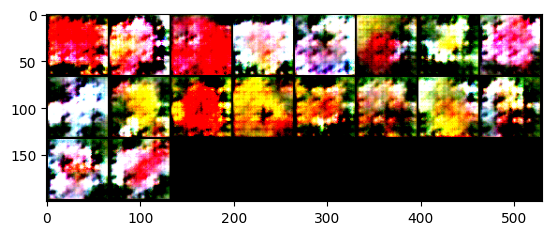

100%|██████████| 103/103 [00:09<00:00, 11.37it/s]


epoch: 6, lossD:0.9212177323484884, lossG:5.810927673450951,lossG_fake:3.44818171019693, lossG_real:2.362745983508027 ,equality:1.0854357266889032


evaluate:127.31792449951172,kid_mean:0.08884891867637634, kid_std:0.040234316140413284,kid_:(tensor(0.0888), tensor(0.0402))


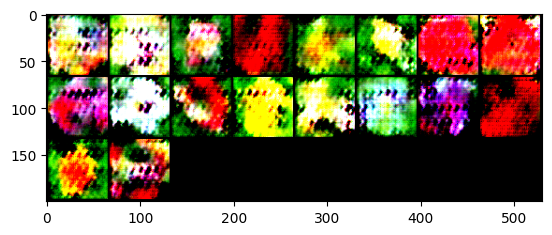

100%|██████████| 103/103 [00:09<00:00, 11.43it/s]


epoch: 7, lossD:0.9585394995305144, lossG:5.628774073517438,lossG_fake:3.276275954200226, lossG_real:2.3524981175811543 ,equality:0.9237778366190716


evaluate:123.6355209350586,kid_mean:0.07958731800317764, kid_std:0.037712614983320236,kid_:(tensor(0.0796), tensor(0.0377))


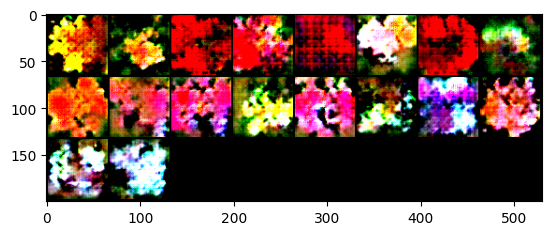

100%|██████████| 103/103 [00:09<00:00, 11.12it/s]


epoch: 8, lossD:1.0269534284050026, lossG:5.364077799528548,lossG_fake:3.0504890535641644, lossG_real:2.3135887691118184 ,equality:0.736900284452346


evaluate:116.27174377441406,kid_mean:0.07981754094362259, kid_std:0.04423295706510544,kid_:(tensor(0.0798), tensor(0.0442))


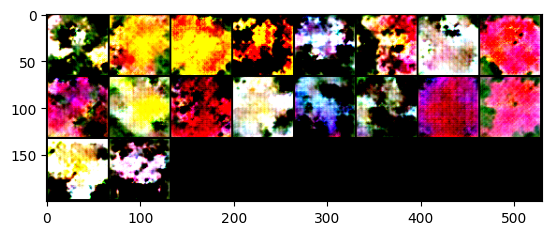

100%|██████████| 103/103 [00:09<00:00, 11.05it/s]


epoch: 9, lossD:1.0414875450643521, lossG:5.23486484138711,lossG_fake:2.937951029504387, lossG_real:2.2969138084106073 ,equality:0.6410372210937796


evaluate:120.79097747802734,kid_mean:0.08724168688058853, kid_std:0.038942091166973114,kid_:(tensor(0.0872), tensor(0.0389))


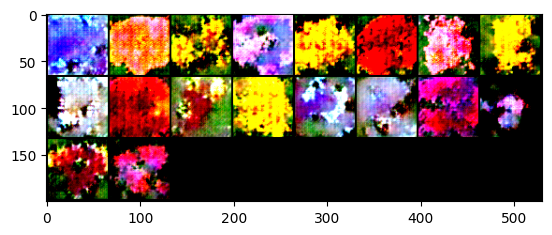

100%|██████████| 103/103 [00:09<00:00, 11.04it/s]


epoch: 10, lossD:1.0769007666018402, lossG:5.100206407528479,lossG_fake:2.85614976373691, lossG_real:2.244056635689967 ,equality:0.612093128046943


evaluate:116.80747985839844,kid_mean:0.08534538000822067, kid_std:0.04010176286101341,kid_:(tensor(0.0853), tensor(0.0401))


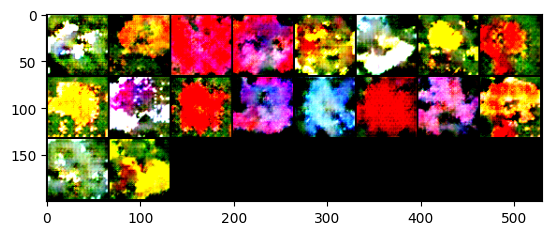

100%|██████████| 103/103 [00:09<00:00, 11.16it/s]


epoch: 11, lossD:1.0269053323754986, lossG:5.271698710987869,lossG_fake:2.963436219298724, lossG_real:2.308262500369433 ,equality:0.6551737189292908


evaluate:114.20098876953125,kid_mean:0.07875632494688034, kid_std:0.03947063162922859,kid_:(tensor(0.0788), tensor(0.0395))


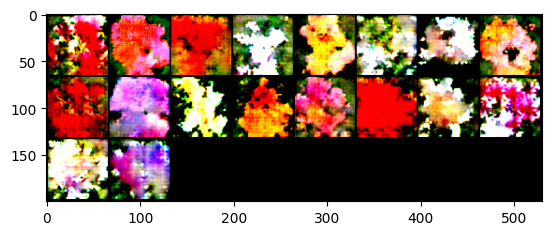

100%|██████████| 103/103 [00:09<00:00, 10.96it/s]


epoch: 12, lossD:0.9982529618207691, lossG:5.231757557507858,lossG_fake:2.925327483890126, lossG_real:2.3064300718816737 ,equality:0.6188974120084523


evaluate:111.07627868652344,kid_mean:0.0854465588927269, kid_std:0.04384097084403038,kid_:(tensor(0.0854), tensor(0.0438))


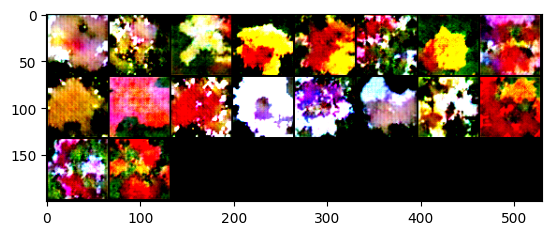

100%|██████████| 103/103 [00:09<00:00, 11.28it/s]


epoch: 13, lossD:0.989340283048963, lossG:5.298705281563175,lossG_fake:2.931011586513334, lossG_real:2.367693697943271 ,equality:0.5633178885700634


evaluate:105.52136993408203,kid_mean:0.0788358822464943, kid_std:0.041660379618406296,kid_:(tensor(0.0788), tensor(0.0417))


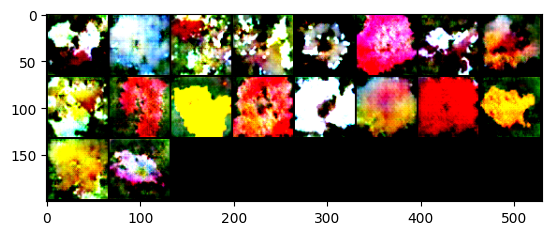

100%|██████████| 103/103 [00:08<00:00, 11.64it/s]


epoch: 14, lossD:0.98235212743861, lossG:5.421335729580481,lossG_fake:2.993428120335329, lossG_real:2.4279076179254404 ,equality:0.5655205024098886


evaluate:104.30365753173828,kid_mean:0.07460257411003113, kid_std:0.038861118257045746,kid_:(tensor(0.0746), tensor(0.0389))


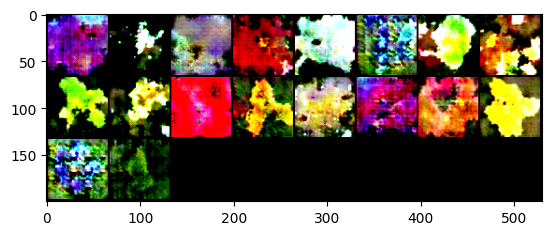

100%|██████████| 103/103 [00:08<00:00, 11.49it/s]


epoch: 15, lossD:0.887361628916657, lossG:5.437534679486913,lossG_fake:3.0058553890117166, lossG_real:2.4316792939473126 ,equality:0.5741760950644039


evaluate:100.15139770507812,kid_mean:0.0691787600517273, kid_std:0.03739415854215622,kid_:(tensor(0.0692), tensor(0.0374))


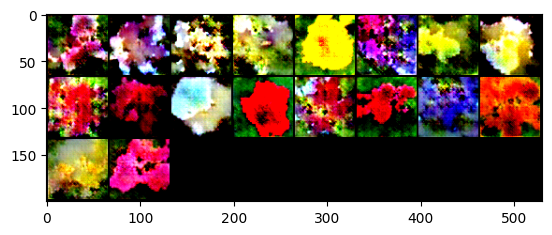

100%|██████████| 103/103 [00:09<00:00, 11.11it/s]


epoch: 16, lossD:0.8225053107564889, lossG:5.586062681327745,lossG_fake:3.0552145798229478, lossG_real:2.530848118286688 ,equality:0.5243664615362595


evaluate:105.10379791259766,kid_mean:0.06526058167219162, kid_std:0.03616303205490112,kid_:(tensor(0.0653), tensor(0.0362))


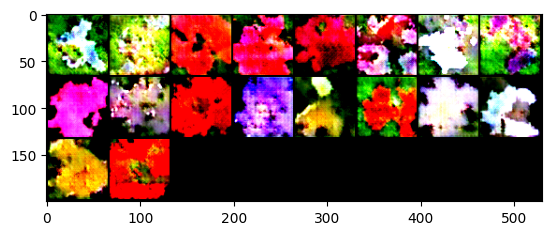

100%|██████████| 103/103 [00:08<00:00, 11.52it/s]


epoch: 17, lossD:0.7934673915354951, lossG:5.702481723526149,lossG_fake:3.087302358405104, lossG_real:2.6151793720652754 ,equality:0.47212298633982863


evaluate:103.47526550292969,kid_mean:0.07417821884155273, kid_std:0.04095551371574402,kid_:(tensor(0.0742), tensor(0.0410))


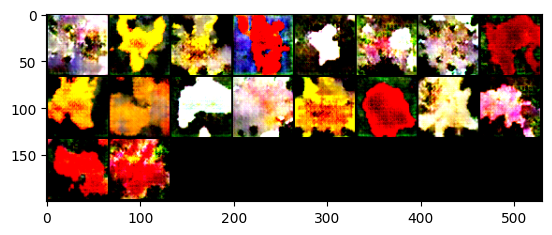

100%|██████████| 103/103 [00:09<00:00, 11.25it/s]


epoch: 18, lossD:0.7221961147287517, lossG:6.052822437101198,lossG_fake:3.3063300558664266, lossG_real:2.7464923789200273 ,equality:0.5598376769463993


evaluate:104.43869018554688,kid_mean:0.07645351439714432, kid_std:0.04007762670516968,kid_:(tensor(0.0765), tensor(0.0401))


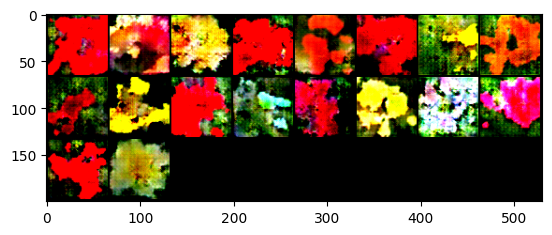

100%|██████████| 103/103 [00:09<00:00, 11.44it/s]


epoch: 19, lossD:0.6979759446914914, lossG:6.041103201005066,lossG_fake:3.274267319336678, lossG_real:2.7668358886126176 ,equality:0.5074314307240604


evaluate:103.80952453613281,kid_mean:0.07170791178941727, kid_std:0.044651519507169724,kid_:(tensor(0.0717), tensor(0.0447))


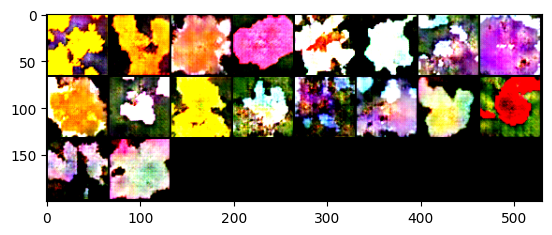

100%|██████████| 103/103 [00:09<00:00, 11.26it/s]


epoch: 20, lossD:0.6332679633955354, lossG:6.251849382826426,lossG_fake:3.4192718047540165, lossG_real:2.8325775520315446 ,equality:0.5866942527224719


evaluate:103.91262817382812,kid_mean:0.07386253774166107, kid_std:0.041912298649549484,kid_:(tensor(0.0739), tensor(0.0419))


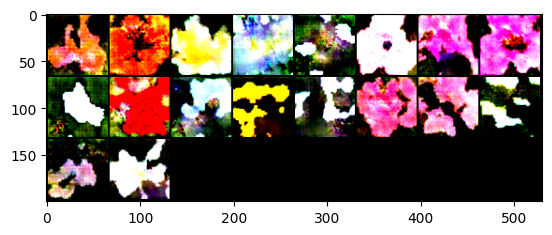

100%|██████████| 103/103 [00:08<00:00, 11.56it/s]


epoch: 21, lossD:0.5816661777716239, lossG:6.472236508304633,lossG_fake:3.5061351072441025, lossG_real:2.966101401639216 ,equality:0.5400337056048863


evaluate:105.72560119628906,kid_mean:0.07835827022790909, kid_std:0.04038847237825394,kid_:(tensor(0.0784), tensor(0.0404))


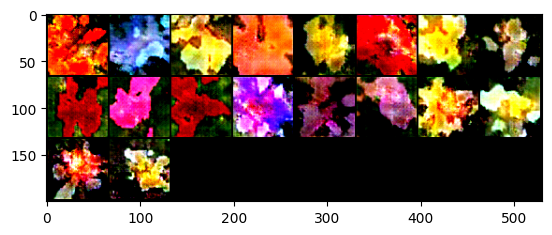

100%|██████████| 103/103 [00:09<00:00, 11.25it/s]


epoch: 22, lossD:0.4494990117630912, lossG:6.611537595397061,lossG_fake:3.5701035562070826, lossG_real:3.041434041504721 ,equality:0.5286695147023615


evaluate:105.36193084716797,kid_mean:0.07118278741836548, kid_std:0.0409325510263443,kid_:(tensor(0.0712), tensor(0.0409))


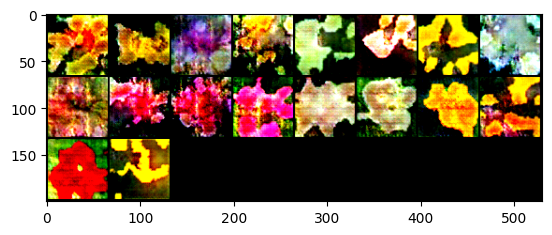

100%|██████████| 103/103 [00:09<00:00, 11.27it/s]


epoch: 23, lossD:0.47666941442101907, lossG:6.738194470266694,lossG_fake:3.6167178003533373, lossG_real:3.121476664415841 ,equality:0.4952411359374964


evaluate:104.7887191772461,kid_mean:0.07330267876386642, kid_std:0.03924684226512909,kid_:(tensor(0.0733), tensor(0.0392))


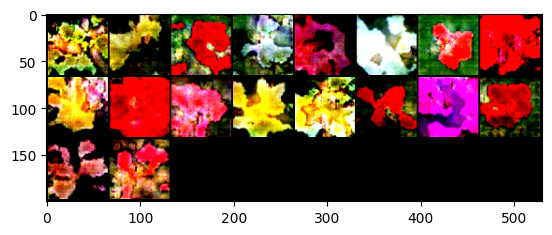

100%|██████████| 103/103 [00:09<00:00, 10.75it/s]


epoch: 24, lossD:0.4227388766277762, lossG:6.926645399297326,lossG_fake:3.679973281124263, lossG_real:3.246672114122261 ,equality:0.4333011670020017


evaluate:104.94303894042969,kid_mean:0.07510501146316528, kid_std:0.03637126833200455,kid_:(tensor(0.0751), tensor(0.0364))


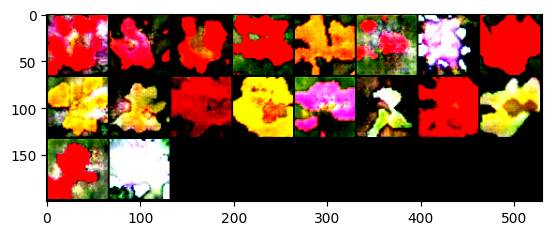

100%|██████████| 103/103 [00:08<00:00, 11.50it/s]


epoch: 25, lossD:0.38265816176545275, lossG:6.8675555581028025,lossG_fake:3.6485230846746455, lossG_real:3.219032485508224 ,equality:0.4294905991664213


evaluate:105.01232147216797,kid_mean:0.07369852066040039, kid_std:0.04083160683512688,kid_:(tensor(0.0737), tensor(0.0408))


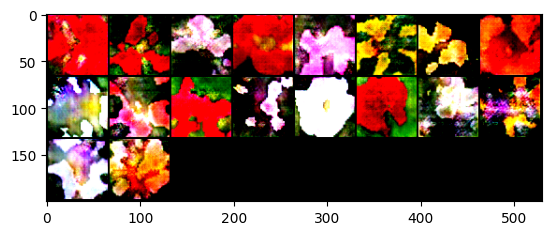

100%|██████████| 103/103 [00:09<00:00, 11.22it/s]


epoch: 26, lossD:0.3134058019128239, lossG:7.196158483190444,lossG_fake:3.838395741379377, lossG_real:3.357762725607863 ,equality:0.48063301577151396


evaluate:105.19252014160156,kid_mean:0.06318861991167068, kid_std:0.031991977244615555,kid_:(tensor(0.0632), tensor(0.0320))


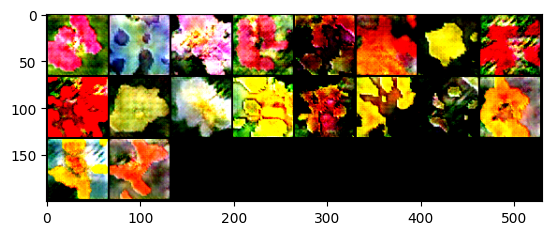

100%|██████████| 103/103 [00:09<00:00, 11.17it/s]


epoch: 27, lossD:0.2530825713703644, lossG:7.347339907896171,lossG_fake:3.901824158372231, lossG_real:3.44551576919926 ,equality:0.4563083891729707


evaluate:106.43002319335938,kid_mean:0.06913724541664124, kid_std:0.03936838358640671,kid_:(tensor(0.0691), tensor(0.0394))


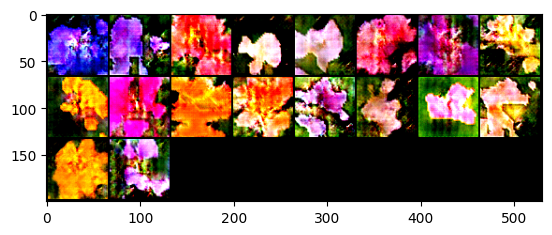

100%|██████████| 103/103 [00:09<00:00, 11.14it/s]


epoch: 28, lossD:0.18752734748266855, lossG:7.692919180231187,lossG_fake:4.13434533702517, lossG_real:3.558573842048645 ,equality:0.5757714949765251


evaluate:107.3067626953125,kid_mean:0.07097751647233963, kid_std:0.041070129722356796,kid_:(tensor(0.0710), tensor(0.0411))


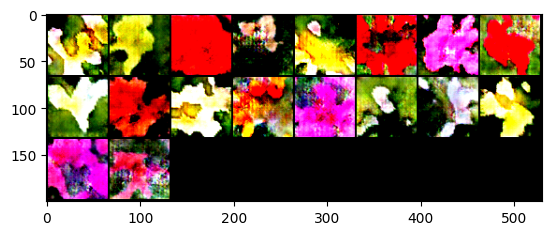

100%|██████████| 103/103 [00:08<00:00, 11.60it/s]


epoch: 29, lossD:0.29826550760749476, lossG:7.724428412983719,lossG_fake:4.216477495952717, lossG_real:3.507950948858724 ,equality:0.7085265470939932


evaluate:107.75826263427734,kid_mean:0.06416955590248108, kid_std:0.03866379335522652,kid_:(tensor(0.0642), tensor(0.0387))


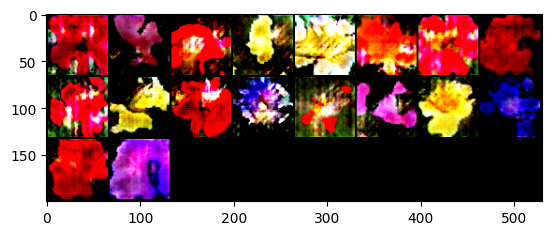

100%|██████████| 103/103 [00:09<00:00, 10.94it/s]


epoch: 30, lossD:0.22693217701269586, lossG:7.860159850814967,lossG_fake:4.236570367535341, lossG_real:3.623589501797574 ,equality:0.6129808657377671


evaluate:109.27540588378906,kid_mean:0.07119368761777878, kid_std:0.03682573512196541,kid_:(tensor(0.0712), tensor(0.0368))


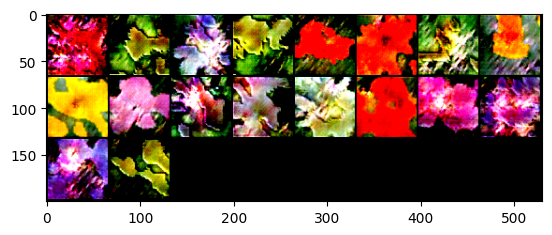

100%|██████████| 103/103 [00:09<00:00, 11.35it/s]


epoch: 31, lossD:0.23419844713604565, lossG:7.8490502024159845,lossG_fake:4.195522010905071, lossG_real:3.6535281816732534 ,equality:0.5419938292318176


evaluate:109.58702087402344,kid_mean:0.07689707726240158, kid_std:0.03739267215132713,kid_:(tensor(0.0769), tensor(0.0374))


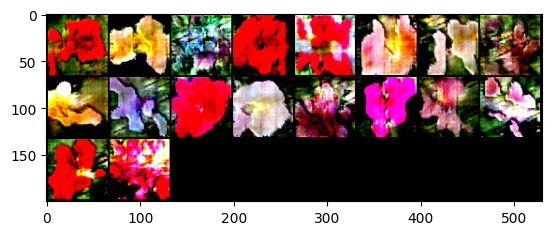

100%|██████████| 103/103 [00:09<00:00, 11.42it/s]


epoch: 32, lossD:0.20758857400816622, lossG:7.926968653225204,lossG_fake:4.250959318818398, lossG_real:3.6760093569755554 ,equality:0.5749499618428429


evaluate:109.74211120605469,kid_mean:0.08153803646564484, kid_std:0.048027485609054565,kid_:(tensor(0.0815), tensor(0.0480))


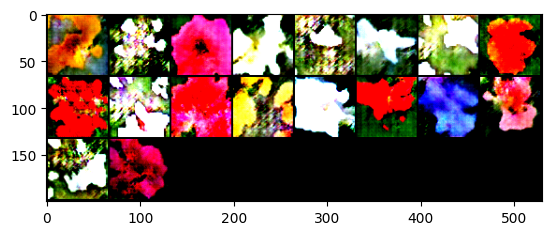

100%|██████████| 103/103 [00:09<00:00, 10.30it/s]


epoch: 33, lossD:0.26470100322684037, lossG:8.039448955684032,lossG_fake:4.289398714755345, lossG_real:3.750050243822116 ,equality:0.5393484709332288


evaluate:109.36506652832031,kid_mean:0.07612104713916779, kid_std:0.0415700227022171,kid_:(tensor(0.0761), tensor(0.0416))


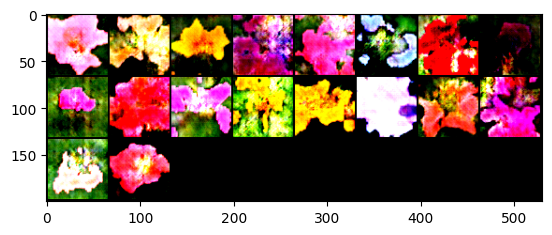

100%|██████████| 103/103 [00:09<00:00, 10.47it/s]


epoch: 34, lossD:0.23286788986579884, lossG:7.869010735484003,lossG_fake:4.145354010526416, lossG_real:3.7236567249575865 ,equality:0.4216972855688299


evaluate:110.037841796875,kid_mean:0.07351300120353699, kid_std:0.03972967341542244,kid_:(tensor(0.0735), tensor(0.0397))


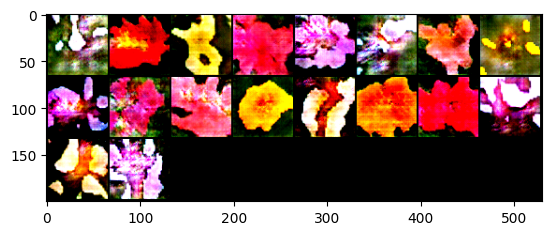

100%|██████████| 103/103 [00:08<00:00, 11.56it/s]


epoch: 35, lossD:0.2182621288936115, lossG:7.789554920011354,lossG_fake:4.102339051302197, lossG_real:3.6872158247290305 ,equality:0.41512322657316636


evaluate:110.72196197509766,kid_mean:0.07612406462430954, kid_std:0.03960128873586655,kid_:(tensor(0.0761), tensor(0.0396))


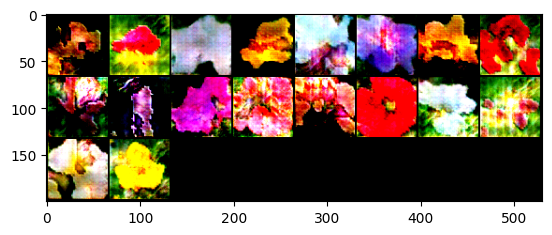

100%|██████████| 103/103 [00:09<00:00, 11.12it/s]


epoch: 36, lossD:0.26640790026381755, lossG:8.254472251077301,lossG_fake:4.4139366612851045, lossG_real:3.8405355921069395 ,equality:0.573401069178165


evaluate:111.37981414794922,kid_mean:0.07097698003053665, kid_std:0.04361431673169136,kid_:(tensor(0.0710), tensor(0.0436))


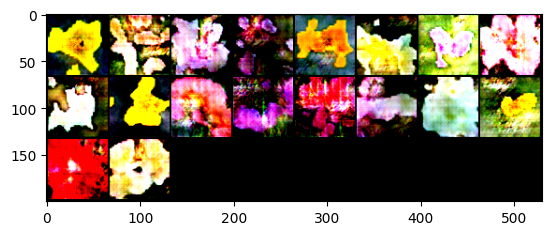

100%|██████████| 103/103 [00:09<00:00, 10.93it/s]


epoch: 37, lossD:0.21511730242484403, lossG:7.940985841658509,lossG_fake:4.254091348462892, lossG_real:3.6868944827792713 ,equality:0.5671968656836208


evaluate:112.03504943847656,kid_mean:0.07837670296430588, kid_std:0.04276706278324127,kid_:(tensor(0.0784), tensor(0.0428))


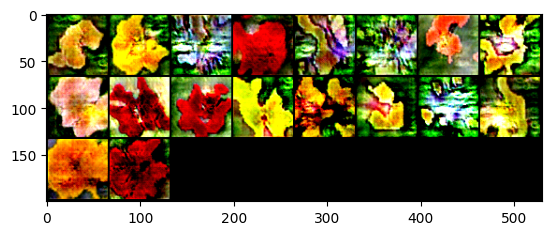

100%|██████████| 103/103 [00:08<00:00, 11.51it/s]


epoch: 38, lossD:0.23495482472540105, lossG:8.316712351678644,lossG_fake:4.479977949151715, lossG_real:3.836734397318757 ,equality:0.6432435518329584


evaluate:110.36726379394531,kid_mean:0.07748698443174362, kid_std:0.03932006284594536,kid_:(tensor(0.0775), tensor(0.0393))


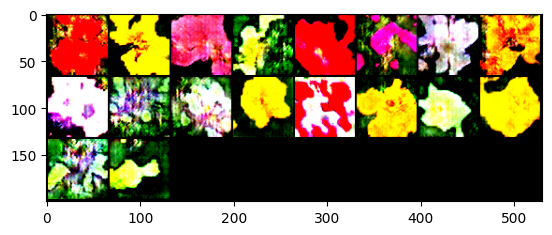

100%|██████████| 103/103 [00:09<00:00, 10.88it/s]


epoch: 39, lossD:0.1890042068129315, lossG:8.255099051207015,lossG_fake:4.400418501455807, lossG_real:3.8546805138726836 ,equality:0.5457379875831232


evaluate:107.80000305175781,kid_mean:0.0727275013923645, kid_std:0.041947245597839355,kid_:(tensor(0.0727), tensor(0.0419))


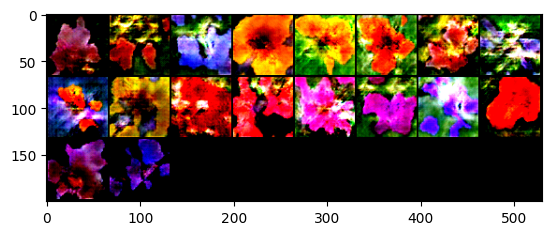

100%|██████████| 103/103 [00:09<00:00, 10.88it/s]


epoch: 40, lossD:0.15862442287209544, lossG:8.349149208624386,lossG_fake:4.419067334202887, lossG_real:3.9300818692133266 ,equality:0.4889854649895602


evaluate:107.40082550048828,kid_mean:0.0704568475484848, kid_std:0.037609830498695374,kid_:(tensor(0.0705), tensor(0.0376))


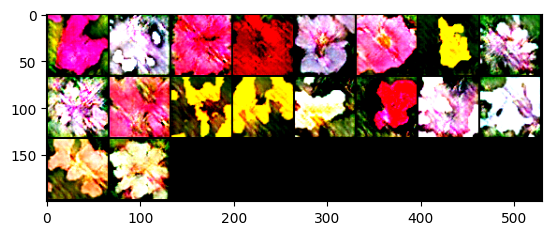

100%|██████████| 103/103 [00:09<00:00, 11.37it/s]


epoch: 41, lossD:0.2970167459033936, lossG:8.569452952412727,lossG_fake:4.708116207307982, lossG_real:3.8613366826066695 ,equality:0.8467795247013123


evaluate:108.36870574951172,kid_mean:0.07912842929363251, kid_std:0.039106905460357666,kid_:(tensor(0.0791), tensor(0.0391))


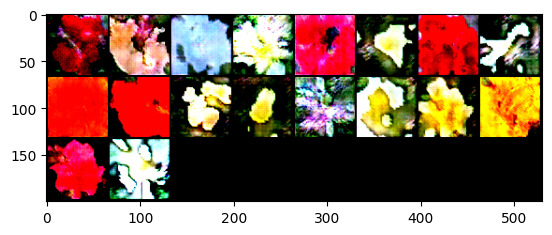

100%|██████████| 103/103 [00:09<00:00, 10.92it/s]


epoch: 42, lossD:0.1671368611560574, lossG:8.384580334413398,lossG_fake:4.449385335144488, lossG_real:3.9351950096852573 ,equality:0.5141903254592304


evaluate:107.56764221191406,kid_mean:0.06938368827104568, kid_std:0.04226123169064522,kid_:(tensor(0.0694), tensor(0.0423))


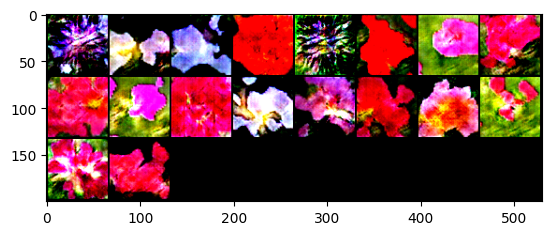

100%|██████████| 103/103 [00:09<00:00, 11.10it/s]


epoch: 43, lossD:0.2549014201080336, lossG:8.812744321174993,lossG_fake:4.845988718051355, lossG_real:3.966755630900559 ,equality:0.8792330871507956


evaluate:108.54837036132812,kid_mean:0.07877235114574432, kid_std:0.040866781026124954,kid_:(tensor(0.0788), tensor(0.0409))


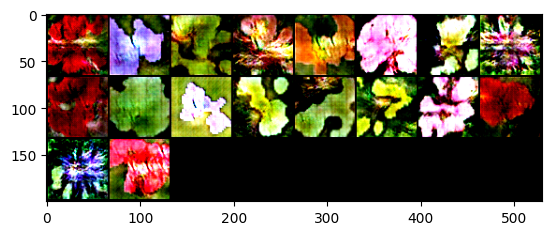

100%|██████████| 103/103 [00:09<00:00, 11.21it/s]


epoch: 44, lossD:0.26045836171912917, lossG:8.62104846435843,lossG_fake:4.653056328736462, lossG_real:3.9679921558759745 ,equality:0.6850641728604878


evaluate:109.8069839477539,kid_mean:0.0758141577243805, kid_std:0.04088281840085983,kid_:(tensor(0.0758), tensor(0.0409))


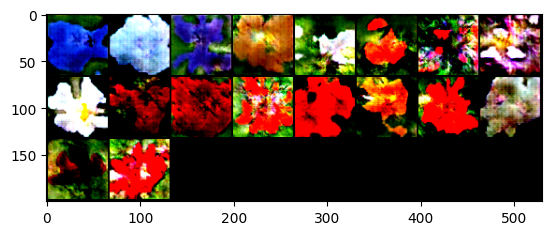

100%|██████████| 103/103 [00:09<00:00, 11.10it/s]


epoch: 45, lossD:0.1824710592989204, lossG:8.500214613757088,lossG_fake:4.550059302339276, lossG_real:3.950155311417811 ,equality:0.5999039909214652


evaluate:109.51563262939453,kid_mean:0.07576670497655869, kid_std:0.03928251564502716,kid_:(tensor(0.0758), tensor(0.0393))


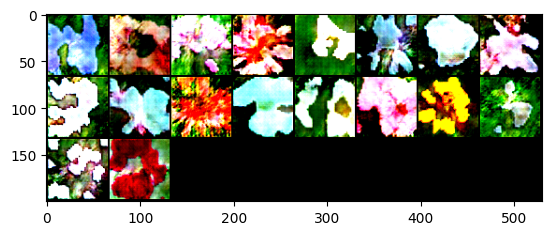

100%|██████████| 103/103 [00:09<00:00, 11.07it/s]


epoch: 46, lossD:0.15991982537348873, lossG:8.763268054110332,lossG_fake:4.705988985820881, lossG_real:4.057279056715734 ,equality:0.6487099291051477


evaluate:108.42330932617188,kid_mean:0.07491935789585114, kid_std:0.04446929693222046,kid_:(tensor(0.0749), tensor(0.0445))


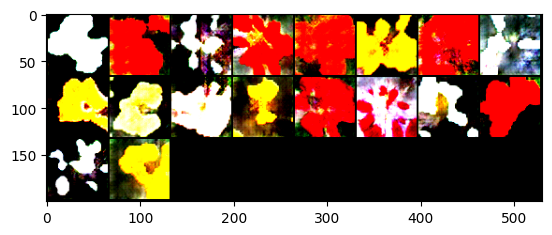

100%|██████████| 103/103 [00:09<00:00, 11.10it/s]


epoch: 47, lossD:0.17415298913940064, lossG:8.933551010576267,lossG_fake:4.824245952865453, lossG_real:4.109305076228762 ,equality:0.7149408766366907


evaluate:109.04191589355469,kid_mean:0.07215391844511032, kid_std:0.040158841758966446,kid_:(tensor(0.0722), tensor(0.0402))


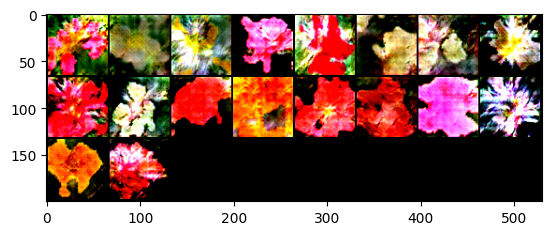

100%|██████████| 103/103 [00:09<00:00, 11.09it/s]


epoch: 48, lossD:0.23692656905182358, lossG:9.044198059341282,lossG_fake:4.956655136589865, lossG_real:4.087542958629942 ,equality:0.8691121779599236


evaluate:108.67293548583984,kid_mean:0.0645151436328888, kid_std:0.04138743504881859,kid_:(tensor(0.0645), tensor(0.0414))


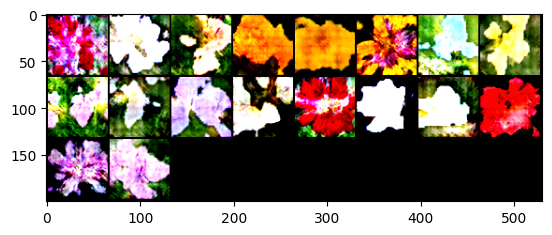

100%|██████████| 103/103 [00:09<00:00, 10.69it/s]


epoch: 49, lossD:0.17826923026332578, lossG:8.80610585444182,lossG_fake:4.659111256738311, lossG_real:4.146994597703507 ,equality:0.5121166590348034


evaluate:108.06806945800781,kid_mean:0.0849948525428772, kid_std:0.04246648773550987,kid_:(tensor(0.0850), tensor(0.0425))


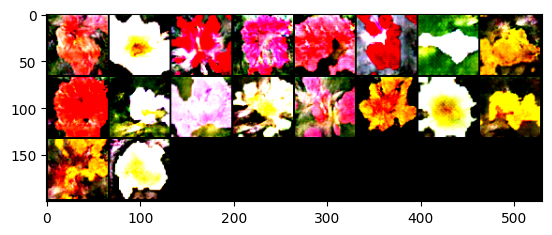

In [44]:
lossesD = []
lossesG = []

raw_lossesD = []
raw_lossesG = []
lossesG_fake = []
lossesG_real = []

equality = 0.0
sum_equality = 0.0
d_equality = []

relu = torch.nn.ReLU()

fid_ = []
kid_mean_ = []
kid_std_ = []
kid_score = []
for epoch in range(opt.n_epoch):
    running_lossD = 0.0 #損失関数初期化
    running_lossG = 0.0
    lossG_fake_running = 0.0
    lossG_real_running = 0.0

    #sum_equality += equality
    equality = 0.0
   # for i , (real_imgs, _) in enumerate(tqdm.tqdm(dataloader, position = 0)):#celebA
    for i , real_imgs in enumerate(tqdm.tqdm(dataloader, position = 0)):#flower
        real_imgs = real_imgs.to(device)
        batch_size = real_imgs.size()[0]
        noise = torch.randn(batch_size, opt.z_dim, 1, 1).to(device)

        #train discriminator

        netD.zero_grad()
        output_real = netD(real_imgs)

        #lossD_real = criterion(output, labels_real)
        lossD_real = torch.mean(relu(1.0 - output_real))


        fake_imgs = netG(noise)##not train  output_fake_d
        output_fake_d = netD(fake_imgs.detach())#not train  output_fake_d

        #lossD_fake = criterion(output, labels_fake)
        lossD_fake = torch.mean(relu(1.0 + output_fake_d))


        lossD = lossD_real + lossD_fake
        #lossD = torch.mean(torch.log(torch.sigmoid(output_real)))- torch.mean(torch.log(torch.sigmoid(output_fake_d)))  #not train  output_fake_d
        lossD.backward()
        optimizerD.step()

        #train generator

        netG.zero_grad()#勾配初期

        output_fake_g = netD(fake_imgs)#train  output_fake_g
        output_real = netD(real_imgs)

        lossG_fake = torch.mean(relu(1.0 - output_fake_g))
        lossG_real = torch.mean(relu(1.0 + output_real))
        #lossG =  torch.mean(torch.log(torch.sigmoid(output_fake_g - output_real))) #- torch.mean(torch.log(torch.sigmoid(output_real)))#train  output_fake_g
        lossG =    lossG_real + lossG_fake


        lossG.backward()
        optimizerG.step()

        # save loss

        running_lossD += lossD.item()
        running_lossG += lossG.item()

        raw_lossesD.append(lossD.item())
        raw_lossesG.append(lossG.item())

        lossG_fake_running += lossG_fake.item()
        lossG_real_running += lossG_real.item()



    running_lossD /=len(dataloader)
    running_lossG /=len(dataloader)

    lossG_fake_running /= len(dataloader)
    lossG_real_running /= len(dataloader)
#equality
    equality = ( lossG_fake_running - lossG_real_running  )
    d_equality.append(equality)


    print("epoch: {}, lossD:{}, lossG:{},lossG_fake:{}, lossG_real:{} ,equality:{}".format(epoch, running_lossD, running_lossG,lossG_fake_running,lossG_real_running,equality))#-->,lossG_fake:{}, lossG_real:{},lossG_fake_running,lossG_real_running
    lossesD.append(running_lossD)
    lossesG.append(running_lossG)

    lossesG_fake.append(lossG_fake_running)
    lossesG_real.append(lossG_real_running)

     #evaluate GAN
    fake_imgs_1 = fake_imgs.detach()
    real_imgs_1 = real_imgs.to(dtype=torch.uint8).cpu()
    fake_imgs_1 = fake_imgs_1.to(dtype=torch.uint8).cpu()
    fid.update(real_imgs_1, real=True)
    fid.update(fake_imgs_1, real=False)
    eval = fid.compute()

    kid.update(real_imgs_1, real=True)
    kid.update(fake_imgs_1, real=False)
    kid_ = kid.compute()
    kid_mean, kid_std = kid.compute()



    print("evaluate:{},kid_mean:{}, kid_std:{},kid_:{}".format(eval, kid_mean, kid_std, kid_))
    fid_.append(eval)
    kid_mean_.append(kid_mean)
    kid_std_.append(kid_std)
    kid_score.append(kid_)
    #show fake image
    grid_imgs = vutils.make_grid(fake_imgs[:24].detach()+0.5)
    grid_imgs_arr = grid_imgs.cpu().numpy()
    plt.imshow(np.transpose(grid_imgs_arr, (1,2,0)))
    plt.show()

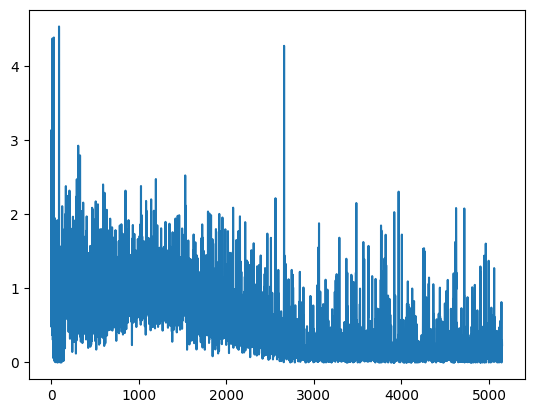

In [45]:
plt.plot(raw_lossesD)

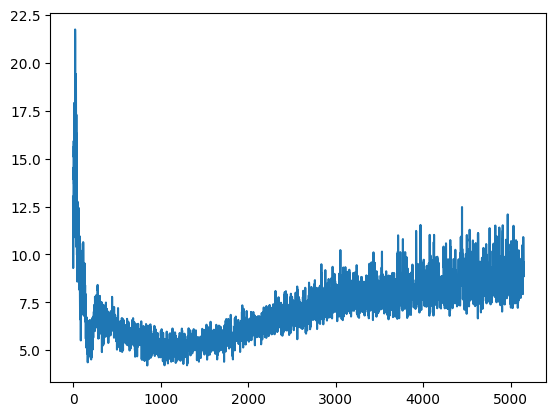

In [46]:
plt.plot(raw_lossesG)

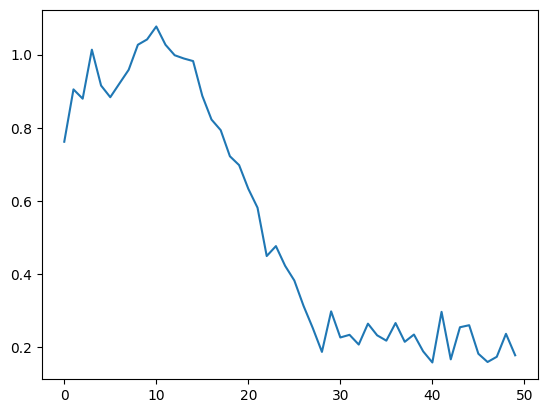

In [47]:
plt.plot(lossesD)

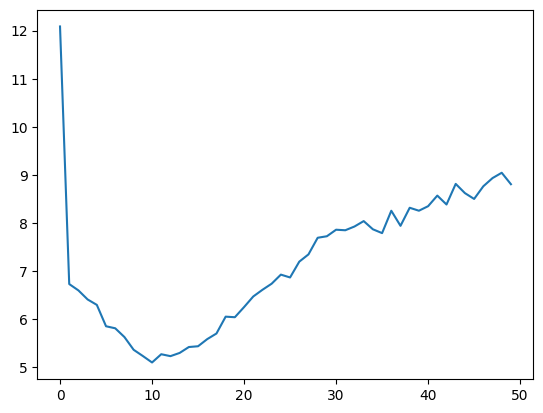

In [48]:
plt.plot(lossesG)

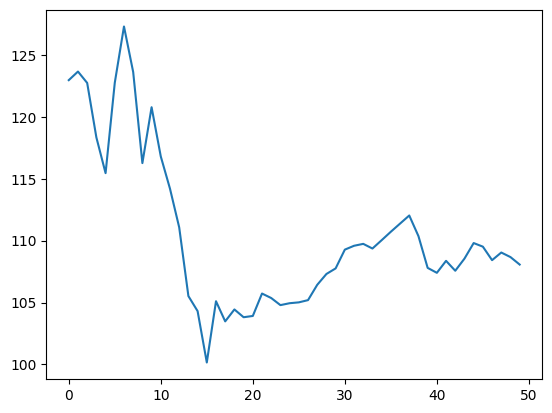

In [49]:
plt.plot(fid_)

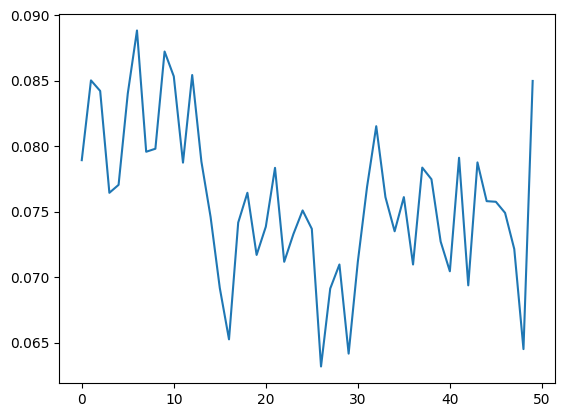

In [50]:
plt.plot(kid_mean_)

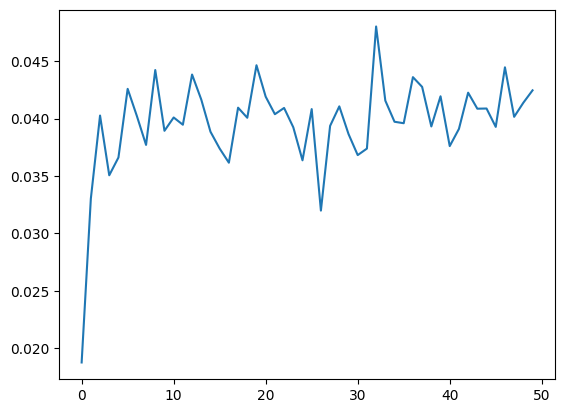

In [51]:
plt.plot(kid_std_)

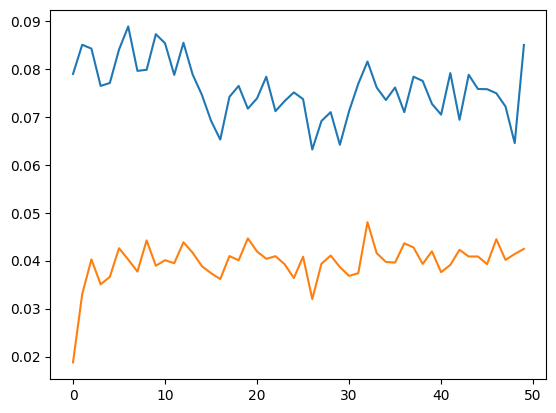

In [52]:
plt.plot(kid_score)

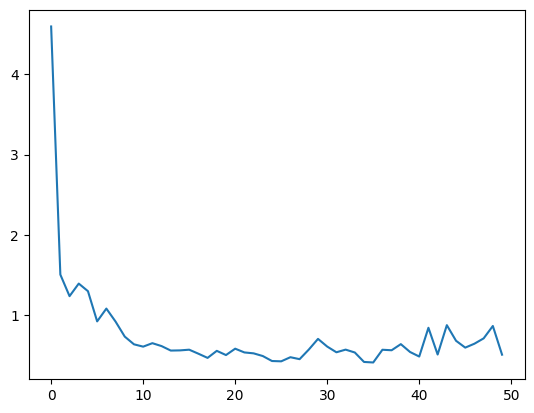

In [53]:
plt.plot(d_equality)

In [54]:
import torch
!pip install torcheval


from torcheval.metrics import PeakSignalNoiseRatio
import torch
import torchvision
#from torcheval.metrics import StructuralSimilarity

real_imgs = real_imgs.to(dtype=torch.uint8).cpu()
fake_imgs = fake_imgs.to(dtype=torch.uint8).cpu()
fid.update(real_imgs, real=True)
fid.update(fake_imgs, real=False)
print(f'fid ',fid.compute())

kid.update(real_imgs, real=True)
kid.update(fake_imgs, real=False)
print(f'kid ',kid.compute())

metric = PeakSignalNoiseRatio()
#input = torch.tensor([[0.1, 0.2], [0.3, 0.4]])
#>>> target = input * 0.9
metric.update(fake_imgs,real_imgs)
print(f'PSNR',metric.compute())#高いほどいい
#PSNR (Peak Signal-to-Noise Ratio): PSNRは、生成画像と本物の画像の間のノイズの量を測定します。高いPSNRは、より低いノイズレベルを示します。

import torch
from skimage.metrics import structural_similarity as ssim
import numpy as np

# 例えば、real_imageが与えられているとします
real_image =real_imgs # 仮のランダムな画像データ
fake_image =fake_imgs
# PyTorch TensorをNumPy配列に変換
real_image_np = real_image.cpu().numpy()

# SSIMを計算するために、0から1の範囲に正規化することが推奨されます
real_image_np = np.clip((real_image_np + 1) / 2.0, 0, 1)

# PyTorch TensorをNumPy配列に変換
fake_image_np = fake_image.cpu().numpy()

# SSIMを計算するために、0から1の範囲に正規化することが推奨されます
fake_image_np = np.clip((fake_image_np + 1) / 2.0, 0, 1)

# SSIMを計算
ssim_value = ssim(real_image_np[0], fake_image_np[0], win_size=3)
print(f"SSIM値: {ssim_value}")
#SSIMは、画像の品質を評価するための指標であり、生成画像と本物の画像の構造的な類似性を測定します。1に近い値が高い品質を示します。

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.2/179.2 kB 3.9 MB/s eta 0:00:00
fid  tensor(107.4880)
kid  (tensor(0.0765), tensor(0.0447))
PSNR tensor(79.6193)
SSIM値: 0.9988757879711873
